# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!pip install --upgrade pip

    100% |████████████████████████████████| 1.4MB 21.4MB/s ta 0:00:01
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1


In [2]:
!pip install imbalanced-learn

     |████████████████████████████████| 163kB 19.3MB/s eta 0:00:01
     |████████████████████████████████| 7.1MB 44.9MB/s eta 0:00:01
     |████████████████████████████████| 296kB 33.8MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3


In [3]:
!pip install xgboost

     |████████████████████████████████| 142.8MB 80kB/s s eta 0:00:01    |████▊                           | 21.2MB 36.1MB/s eta 0:00:04     |█████████                       | 40.3MB 36.1MB/s eta 0:00:03


In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pickle
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from imblearn.combine import SMOTEENN

from xgboost import XGBClassifier
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [6]:
# load in the data
azdias = pd.read_csv('AZDIAS.csv', index_col= 'LNR')
customers = pd.read_csv('Customers.csv', index_col= 'LNR')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
#Loading Missing Value Checkbook
missing_value_checkbook= pd.read_excel('Missing Value Checkbook.xlsx', sheet_name = 'Tabelle1')

### 0.1 Data Exploration and Feature Selection

In [8]:
# data shape
azdias.shape

(891221, 366)

In [9]:
# data info
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Columns: 366 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [10]:
azdias.describe()

,Unnamed: 0,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,891221.000000,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,445610.000000,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,257273.486465,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,0.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,222805.000000,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,445610.000000,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,668415.000000,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,891220.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [11]:
missing_value_checkbook.shape

(1838, 4)

In [12]:
missing_value_checkbook.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
2,ALTER_HH,main age within the household,0,unknown / no main age detectable
3,ANREDE_KZ,gender,"-1, 0",unknown
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)


In [13]:
# droping NaN in Attribute
missing_value_checkbook = missing_value_checkbook[~missing_value_checkbook['Attribute'].isnull()]

In [14]:
missing_value_checkbook = missing_value_checkbook.set_index('Attribute')

In [15]:
missing_value_checkbook = missing_value_checkbook.T

In [16]:
missing_value_checkbook.head()

Attribute,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,BIP_FLAG,...,SEMIO_VERT,SHOPPER_TYP,SOHO_FLAG,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,WACHSTUMSGEBIET_NB,W_KEIT_KIND_HH,ZABEOTYP
Description,best-ager typology,age classification through prename analysis,main age within the household,gender,number of households in the building,number of academic title holder in building,number of adult persons in the household,number of professional title holder in household,distance to next urban centre,business-flag indicating companies in the buil...,...,affinity indicating in what way the person is ...,shopping typology,small office/home office flag,flag whether this person holds an academic title,insurance typology,length of residence,residential-area,growing area (population growth in the last 5 ...,likelihood of a child present in this household,typification of energy consumers
Value,-1,"-1, 0",0,"-1, 0",…,…,…,…,-1,-1,...,"-1, 9",-1,-1,"-1, 0",-1,"-1, 0",-1,"-1, 0","-1, 0","-1, 9"
Meaning,unknown,unknown,unknown / no main age detectable,unknown,numeric value (typically coded from 1-10),numeric value (typically coded from 1-10),numeric value (typically coded from 1-3),numeric value (typically coded from 1-10),unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown


In [17]:
# dropping any attributes related to what cars are prevalent in the area, since I don't think that will be useful infromation.
missing_value_checkbook = missing_value_checkbook[missing_value_checkbook.columns.drop(list(missing_value_checkbook.filter(regex='KBA')))]

In [18]:
# getting a list of the attributes elaborated on in the excel file
list_of_dias_attributes = list(missing_value_checkbook.columns)

In [19]:
len(list_of_dias_attributes)

141

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Experimental Data Cleaning

In [20]:
# dropping any column that is in azdias but not explained in DIAS Attributes
azdias = azdias.filter(items=list_of_dias_attributes)
azdias.shape

(891221, 100)

In [21]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
LNR,,,,,,,,,,,,,,,,,,,,,
910215,-1,2,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,2,3,1,-1,NaN,-1,NaN,NaN,NaN,3
910220,-1,1,0.0,2,11.0,0.0,2.0,0.0,6.0,8,...,5,6,1,3,0.0,2,9.0,4.0,3.0,5
910225,-1,3,17.0,2,10.0,0.0,1.0,0.0,2.0,4,...,4,3,4,2,0.0,1,9.0,2.0,3.0,5
910226,2,4,13.0,2,1.0,0.0,0.0,0.0,4.0,2,...,5,4,4,1,0.0,1,9.0,7.0,NaN,3
910241,-1,3,20.0,1,3.0,0.0,4.0,0.0,2.0,6,...,6,2,7,2,0.0,2,9.0,3.0,2.0,4


In [22]:
remaining_features = list(azdias.columns)

In [23]:
missing_value_checkbook = missing_value_checkbook.filter(items=remaining_features)

In [24]:
missing_value_checkbook.to_csv('DIAS_Missing_Data_Codes.csv')

First we will look for collumns with unusual volume of NaNs, we will likely want to drop these as they could prove problematic for our kmeans clustering. Looking at the provided excel sheet DIAS Attributes 2017 we also know that -1 is used in some collumns to describe missing data as well so we will replace all instances with NaNs.

In [25]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
LNR,,,,,,,,,,,,,,,,,,,,,
910215,-1,2,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,2,3,1,-1,NaN,-1,NaN,NaN,NaN,3
910220,-1,1,0.0,2,11.0,0.0,2.0,0.0,6.0,8,...,5,6,1,3,0.0,2,9.0,4.0,3.0,5
910225,-1,3,17.0,2,10.0,0.0,1.0,0.0,2.0,4,...,4,3,4,2,0.0,1,9.0,2.0,3.0,5
910226,2,4,13.0,2,1.0,0.0,0.0,0.0,4.0,2,...,5,4,4,1,0.0,1,9.0,7.0,NaN,3
910241,-1,3,20.0,1,3.0,0.0,4.0,0.0,2.0,6,...,6,2,7,2,0.0,2,9.0,3.0,2.0,4


In [26]:
#standardizing encoding of missing values to be NaN
for att in missing_value_checkbook.columns:
    azdias.loc[azdias[att].isin(missing_value_checkbook[att]), att] = np.nan

In [27]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
LNR,,,,,,,,,,,,,,,,,,,,,
910215,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0
910220,NaN,1.0,NaN,2.0,11.0,0.0,2.0,0.0,6.0,8,...,5.0,6.0,1.0,3.0,0.0,2.0,9.0,4.0,3.0,5.0
910225,NaN,3.0,17.0,2.0,10.0,0.0,1.0,0.0,2.0,4,...,4.0,3.0,4.0,2.0,0.0,1.0,9.0,2.0,3.0,5.0
910226,2.0,4.0,13.0,2.0,1.0,0.0,0.0,0.0,4.0,2,...,5.0,4.0,4.0,1.0,0.0,1.0,9.0,7.0,NaN,3.0
910241,NaN,3.0,20.0,1.0,3.0,0.0,4.0,0.0,2.0,6,...,6.0,2.0,7.0,2.0,0.0,2.0,9.0,3.0,2.0,4.0


In [28]:
# assessing missing data in each column
col_nan = 100*azdias.isna().sum()/len(azdias)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


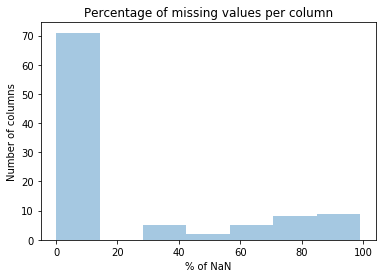

In [31]:
plt.figure()
sns.distplot(col_nan.values, kde=False)
plt.ylabel('Number of columns')
plt.xlabel('% of NaN')
plt.title('Percentage of missing values per column')
plt.show()

Collumns with more than 30% missing data seem the exception and could hurt our clustering. We will drop them. 

In [32]:
# defining colums to drop
col_nan_drop_threshold = col_nan[col_nan > 30]
high_nan_cols = list(col_nan_drop_threshold.index)
# checking columns to be romoved
len(high_nan_cols)
print(high_nan_cols)

['AGER_TYP', 'ALTER_HH', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'MOBI_REGIO', 'PLZ8_BAUMAX']


In [33]:
# dropping high NaN collumns
azdias.drop(high_nan_cols, axis = 1, inplace = True)
azdias.shape

(891221, 73)

We will also want to have a look at rows with unusually high NaNs and remove those as well. 

In [34]:
# assessing missing data in each row
row_nan = 100*azdias.isnull().sum(axis=1)/len(azdias.columns)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


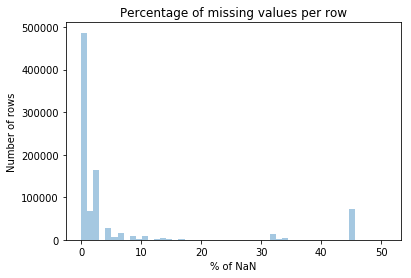

In [35]:
plt.figure()
sns.distplot(row_nan.values, kde=False)
plt.ylabel('Number of rows')
plt.xlabel('% of NaN')
plt.title('Percentage of missing values per row')
plt.show()

Dropping Rows with unusually high NaNs (>30%).

In [36]:
# defining rows to drop
row_nan_drop_threshold = row_nan[row_nan > 30]
high_nan_rows = list(row_nan_drop_threshold.index)
# checking number of rows to be romoved
len(high_nan_rows)

93154

In [37]:
# dropping high NaN rows
azdias.drop(high_nan_rows, axis = 0, inplace = True)
azdias.shape

(798067, 73)

In [38]:
# checking what features remain
pd.set_option('max_columns', 280)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,EWDICHTE,FINANZTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
910220,1.0,2.0,11.0,0.0,2.0,0.0,6.0,8,8A,5.0,NaN,10.0,NaN,3.0,1.0,5.0,5.0,1.0,5.0,4.0,2.0,8.0,3.0,1996.0,10.0,0.0,3.0,6.0,8.0,2.0,1.0,5.0,3.0,21.0,6.0,2.0,1.0,1992.0,1.0,3.0,5.0,W,2.0,3.0,2.0,1.0,4.0,5.0,14.0,3.0,4.0,1.0,7.0,2.0,4.0,4.0,4.0,3.0,2.0,3.0,7.0,6.0,4.0,5.0,6.0,1.0,3.0,0.0,2.0,9.0,4.0,3.0,5.0
910225,3.0,2.0,10.0,0.0,1.0,0.0,2.0,4,4C,3.0,0.0,10.0,9.0,4.0,1.0,2.0,5.0,1.0,4.0,3.0,1.0,1.0,4.0,1979.0,10.0,1.0,3.0,4.0,4.0,2.0,5.0,1.0,1.0,3.0,1.0,3.0,2.0,1992.0,1.0,2.0,5.0,W,3.0,3.0,1.0,0.0,4.0,4.0,15.0,2.0,2.0,3.0,7.0,6.0,1.0,7.0,7.0,3.0,4.0,3.0,3.0,4.0,3.0,4.0,3.0,4.0,2.0,0.0,1.0,9.0,2.0,3.0,5.0
910226,4.0,2.0,1.0,0.0,0.0,0.0,4.0,2,2A,2.0,0.0,10.0,9.0,2.0,6.0,2.0,2.0,4.0,2.0,1.0,5.0,1.0,4.0,1957.0,1.0,0.0,2.0,1.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0,9.0,4.0,1997.0,1.0,1.0,3.0,W,2.0,2.0,2.0,0.0,4.0,3.0,8.0,0.0,3.0,2.0,4.0,7.0,1.0,5.0,4.0,4.0,4.0,1.0,4.0,3.0,2.0,5.0,4.0,4.0,1.0,0.0,1.0,9.0,7.0,NaN,3.0
910241,3.0,1.0,3.0,0.0,4.0,0.0,2.0,6,6B,5.0,10.0,NaN,1.0,5.0,5.0,1.0,2.0,4.0,3.0,3.0,4.0,1.0,5.0,1963.0,5.0,0.0,3.0,5.0,1.0,3.0,4.0,10.0,5.0,32.0,10.0,3.0,2.0,1992.0,1.0,5.0,6.0,W,2.0,4.0,2.0,1.0,3.0,3.0,8.0,5.0,5.0,5.0,2.0,4.0,4.0,2.0,3.0,6.0,4.0,2.0,4.0,2.0,4.0,6.0,2.0,7.0,2.0,0.0,2.0,9.0,3.0,2.0,4.0
910244,1.0,2.0,5.0,0.0,1.0,0.0,6.0,8,8C,2.0,0.0,3.0,4.0,2.0,2.0,2.0,5.0,3.0,1.0,2.0,5.0,1.0,4.0,1943.0,1.0,0.0,3.0,5.0,7.0,4.0,5.0,1.0,1.0,8.0,2.0,4.0,2.0,1992.0,1.0,1.0,3.0,W,2.0,3.0,1.0,1.0,5.0,5.0,3.0,5.0,3.0,3.0,4.0,2.0,4.0,4.0,4.0,5.0,2.0,4.0,7.0,7.0,7.0,2.0,6.0,2.0,0.0,0.0,2.0,9.0,7.0,6.0,4.0


In [39]:
preprocessed_features = list(azdias.columns)

In [40]:
with open('preprocessed_features.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(preprocessed_features, filehandle)

In [41]:
cleaning_fuction_missing_value_cb = missing_value_checkbook.filter(items = preprocessed_features)
cleaning_fuction_missing_value_cb.to_csv('Missing Value Checkbook for the Cleaning Fuction.csv')

In [42]:
#determining which variables represent non-sequential categorical data which require one-hot encoding.
needs_one_hot= ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP',
                'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP',  
                'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 
                'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB', 
                'LP_STATUS_FEIN', 'LP_STATUS_GROB',
                'NATIONALITAET_KZ','PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 
                'RETOURTYP_BK_S', 'SHOPPER_TYP', 'ZABEOTYP']

In [43]:
#re-encoding OST_WEST_KZ as numeric variable
azdias['OST_WEST_KZ'] =  azdias['OST_WEST_KZ'].map({'W': 1, 'O': 2})

In [44]:
#encoding non-sequential categorical variables as one-hot
azdias_cleaned = pd.get_dummies(azdias, columns=needs_one_hot)

In [45]:
azdias_cleaned.shape

(798067, 286)

In [46]:
# saving cleaned data to csv
azdias_cleaned.to_csv('Cleaned_AZDIAS.csv')

### 1.2 Data Cleaning

#### Defining the Cleaning Fuction
This cleaning fuction combines all steps from the experimental cleaning.

In [5]:
# reading in data for the cleaning fuction
with open('preprocessed_features.data', 'rb') as filehandle:
    # read the data as binary data stream
    preprocessed_features = pickle.load(filehandle)

mvc = pd.read_csv('Missing Value Checkbook for the Cleaning Fuction.csv', index_col = 0)

In [6]:
# defining the data cleaning fuction
def clean_data(df, preprocessed_features = preprocessed_features, mvc = mvc, drop_row=True):
    '''
    Inputs: df: data frame to be cleaned 
            preprocessed_features: list of features/columns to be kept 
            mvc = dataframe showing which values encode missing data
    Output: Cleaned Data
    '''
    # applying filter based on preprocessed data dropping high NaN columns and features not explained in DIAS Attribute 2017
    df = df.filter(items = preprocessed_features)
    
    # consistently encode missing values as NaN
    for att in mvc.columns:
        df.loc[df[att].isin(mvc[att]), att] = np.nan
    
    # calculating NaN % in rows and dropping those above the threshold
    if drop_row:
        row_nan = df.isnull().sum(axis=1)/len(df.columns)
        row_nan_drop_threshold = row_nan[row_nan > 0.3]
        high_nan_rows = list(row_nan_drop_threshold.index)
        df = df.drop(high_nan_rows, axis = 0)
    
    # re-encoding OST_WEST_KZ as numeric variable
    df['OST_WEST_KZ'] =  df['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    
    needs_one_hot= ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP',
                    'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 
                    'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 
                    'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB', 
                    'LP_STATUS_FEIN', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ','PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 
                    'RETOURTYP_BK_S', 'SHOPPER_TYP', 'ZABEOTYP']
    # re-encoding non-sequential categorical variables as one-hot
    df = pd.get_dummies(df, columns=needs_one_hot)
    return df

We will now clean the customer data and save it to csv so we do not have to run through the time consuming cleaning process again.

In [51]:
customers_cleaned = clean_data(customers)
customers_cleaned.shape
customers_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_DATUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KKK,KONSUMNAEHE,MIN_GEBAEUDEJAHR,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,RELAT_AB,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,D19_KONSUMTYP_1.0,D19_KONSUMTYP_2.0,D19_KONSUMTYP_3.0,D19_KONSUMTYP_4.0,D19_KONSUMTYP_5.0,D19_KONSUMTYP_6.0,D19_KONSUMTYP_9.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,...,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_0.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_0.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_LEBENSPHASE_FEIN_0.0,LP_LEBENSPHASE_FEIN_1.0,LP_LEBENSPHASE_FEIN_2.0,LP_LEBENSPHASE_FEIN_3.0,LP_LEBENSPHASE_FEIN_4.0,LP_LEBENSPHASE_FEIN_5.0,LP_LEBENSPHASE_FEIN_6.0,LP_LEBENSPHASE_FEIN_7.0,LP_LEBENSPHASE_FEIN_8.0,LP_LEBENSPHASE_FEIN_9.0,LP_LEBENSPHASE_FEIN_10.0,LP_LEBENSPHASE_FEIN_11.0,LP_LEBENSPHASE_FEIN_12.0,LP_LEBENSPHASE_FEIN_13.0,LP_LEBENSPHASE_FEIN_14.0,LP_LEBENSPHASE_FEIN_15.0,LP_LEBENSPHASE_FEIN_16.0,LP_LEBENSPHASE_FEIN_17.0,LP_LEBENSPHASE_FEIN_18.0,LP_LEBENSPHASE_FEIN_19.0,LP_LEBENSPHASE_FEIN_20.0,LP_LEBENSPHASE_FEIN_21.0,LP_LEBENSPHASE_FEIN_22.0,LP_LEBENSPHASE_FEIN_23.0,LP_LEBENSPHASE_FEIN_24.0,LP_LEBENSPHASE_FEIN_25.0,LP_LEBENSPHASE_FEIN_26.0,LP_LEBENSPHASE_FEIN_27.0,LP_LEBENSPHASE_FEIN_28.0,LP_LEBENSPHASE_FEIN_29.0,LP_LEBENSPHASE_FEIN_30.0,LP_LEBENSPHASE_FEIN_31.0,LP_LEBENSPHASE_FEIN_32.0,LP_LEBENSPHASE_FEIN_33.0,LP_LEBENSPHASE_FEIN_34.0,LP_LEBENSPHASE_FEIN_35.0,LP_LEBENSPHASE_FEIN_36.0,LP_LEBENSPHASE_FEIN_37.0,LP_LEBENSPHASE_FEIN_38.0,LP_LEBENSPHASE_FEIN_39.0,LP_LEBENSPHASE_FEIN_40.0,LP_LEBENSPHASE_GROB_0.0,LP_LEBENSPHASE_GROB_1.0,LP_LEBENSPHASE_GROB_2.0,LP_LEBENSPHASE_GROB_3.0,LP_LEBENSPHASE_GROB_4.0,LP_LEBENSPHASE_GROB_5.0,LP_LEBENSPHASE_GROB_6.0,LP_LEBENSPHASE_GROB_7.0,LP_LE

In [52]:
customers_cleaned.to_csv('Cleaned_Customers.csv')

### 1.3 Scaling and Dimensionality Reduction

In [53]:
#reading in the cleaned data
azdias_cleaned = pd.read_csv('Cleaned_AZDIAS.csv', index_col= 'LNR')
customers_cleaned = pd.read_csv('Cleaned_Customers.csv', index_col= 'LNR')

In [55]:
# selecting imputer to replace missing values
imp = SimpleImputer(missing_values=np.nan, strategy='median')
azdias_imp = pd.DataFrame(imp.fit_transform(azdias_cleaned.values),
                          columns=azdias_cleaned.columns)
customers_imp = pd.DataFrame(imp.transform(customers_cleaned.values),
                          columns=customers_cleaned.columns)

In [56]:
# appling feature scaling to the general population demographics and customer data

scaler = RobustScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imp.values),
                          columns=azdias_imp.columns)
customers_scaled = pd.DataFrame(scaler.transform(customers_imp.values),
                          columns=customers_imp.columns)

In [57]:
# cleaning up variables
del azdias_imp
del customers_imp

In [58]:
# performing principle components analysis on the scaled data
pca = PCA().fit(azdias_scaled)

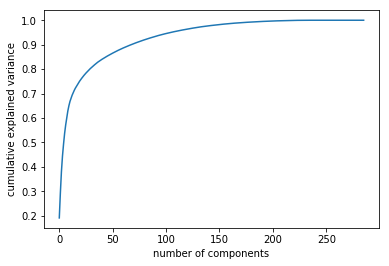

In [59]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

It appears that 200 components appear to explain well over 95% of the variance in our scaled data.

In [60]:
#re-fitting PCA with selected number of components. 
pca = PCA(n_components=200)
azdias_pca = pca.fit_transform(azdias_scaled)
customers_pca = pca.transform(customers_scaled)

### 1.4 K-means Custering

In [63]:
# defining fuction to compute the average intra-cluster distance in kmeans clustered data


def get_kmeans_score(data, c):
    '''
    returns the Sum of Squared Error as a measure of distance from data points to cluster centers
    INPUT:
        data - the dataset you want to fit kmeans to
        c - the number of selected centers (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    # instantiating kmeans
    kmeans = MiniBatchKMeans(n_clusters=c, random_state = 1)

    # fitting the model to your data using the fit method
    model = kmeans.fit(data)
    
    # obtaing SSE score related to the fit model
    score = np.abs(model.score(data))
    
    return score

We will iterate over a selection of plausible numbers of clusters and get SSE scores for each. This will allow us to select the number of clusters we actually want to use for our final segmentation. The goal is to select clusters so that all of our target market segment, people similar to our existing customer base, fall into a single cluster, or are at least clearly sperated from the rest of the population.

In [64]:
# initiating an empty list of scores and defining a range of clusters to be investigated
score_list = []
clusters = np.arange(2, 20, 1)

# iterating over a range of clusters from 2 to 10
for c in clusters: 
    score_list.append(get_kmeans_score(azdias_pca, c))

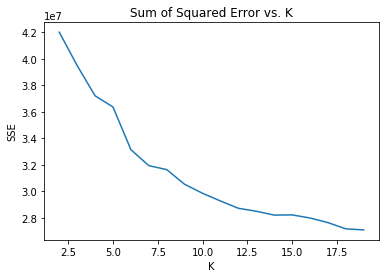

In [65]:
# investigating the change in intra-cluster distance across selected variation of clusters

plt.figure() 
plt.plot(clusters, score_list);
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Sum of Squared Error vs. K')
plt.show()

Selecting 7, or 14 clusters seem to be solid choices. No very well defined elbow is visible.

### 1.5 Cluster Analysis

In [67]:
#fitting the k-means model with selected number of clusters
kmeans7 = KMeans(n_clusters=7, random_state = 1)
azdias_labels7 = kmeans7.fit_predict(azdias_pca)

In [68]:
cluster_count_azdias7 = pd.Series(azdias_labels7).value_counts()

clusters_azdias7 = pd.DataFrame({'cluster': cluster_count_azdias7.index,
                           '% of data': 100*cluster_count_azdias7.values/len(azdias_labels7)})
clusters_azdias7['data'] = 'general population'

# printing clusters_azdias
clusters_azdias7

,cluster,% of data,data
0,3,32.801883,general population
1,0,22.740196,general population
2,4,17.906642,general population
3,5,14.123000,general population
4,1,5.951004,general population
5,2,5.132025,general population
6,6,1.345250,general population


Generating labels for the existing customers using the K-means model fit to the general population data.

In [70]:
customers_labels7 = kmeans7.predict(customers_pca)

In [72]:
cluster_count_customers7 = pd.Series(customers_labels7).value_counts()

clusters_customers7 = pd.DataFrame({'cluster': cluster_count_customers7.index,
                           '% of data': 100*cluster_count_customers7.values/len(customers_labels7)})
clusters_customers7['data'] = 'customers'

# printing clusters_customers
clusters_customers7

,cluster,% of data,data
0,3,60.329511,customers
1,0,22.769448,customers
2,1,5.169871,customers
3,2,4.400776,customers
4,5,3.703651,customers
5,4,2.764509,customers
6,6,0.862233,customers


Comparing general population and customer clustering.

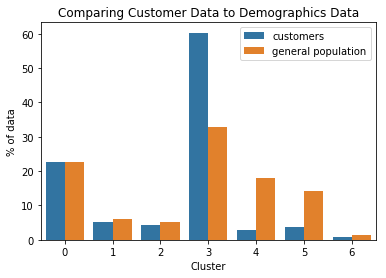

In [73]:
plt.figure()
sns.barplot(x="cluster", y="% of data", hue="data",
            data=pd.concat([clusters_customers7, clusters_azdias7]))
plt.xlabel('Cluster')
plt.ylabel('% of data')
plt.title('Comparing Customer Data to Demographics Data')
plt.legend()
plt.show()

#### 1.5a Findings 7 clusters:
We can see that customers are clearly overrepresented compared to the general population in cluster 3, and underrepresented in clusters 4 and 5. Cluster 3 represents just under 33% of the population and over 60% of customers.

In [74]:
#fitting the k-means model with selected number of clusters
kmeans14 = KMeans(n_clusters=14, random_state = 1)
azdias_labels14 = kmeans14.fit_predict(azdias_pca)

In [75]:
cluster_count_azdias14 = pd.Series(azdias_labels14).value_counts()

clusters_azdias14 = pd.DataFrame({'cluster': cluster_count_azdias14.index,
                           '% of data': 100*cluster_count_azdias14.values/len(azdias_labels14)})
clusters_azdias14['data'] = 'general population'

# printing clusters_azdias
clusters_azdias14

,cluster,% of data,data
0,12,12.887013,general population
1,10,11.197556,general population
2,9,11.176129,general population
3,1,10.595351,general population
4,8,10.333594,general population
5,0,10.137119,general population
6,7,7.167193,general population
7,4,7.125718,general population
8,5,5.420347,general population
9,3,5.125885,general population


In [76]:
customers_labels14 = kmeans14.predict(customers_pca)

In [77]:
cluster_count_customers14 = pd.Series(customers_labels14).value_counts()

clusters_customers14 = pd.DataFrame({'cluster': cluster_count_customers14.index,
                           '% of data': 100*cluster_count_customers14.values/len(customers_labels14)})
clusters_customers14['data'] = 'customers'

# printing clusters_customers
clusters_customers14

,cluster,% of data,data
0,1,30.636797,customers
1,12,21.411889,customers
2,9,13.792909,customers
3,10,10.105486,customers
4,5,5.747751,customers
5,3,4.377492,customers
6,11,3.426354,customers
7,7,2.455460,customers
8,8,2.315752,customers
9,13,1.529723,customers


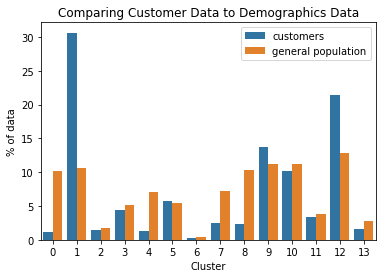

In [78]:
plt.figure()
sns.barplot(x="cluster", y="% of data", hue="data",
            data=pd.concat([clusters_customers14, clusters_azdias14]))
plt.xlabel('Cluster')
plt.ylabel('% of data')
plt.title('Comparing Customer Data to Demographics Data')
plt.legend()
plt.show()

#### 1.5b Findings 14 Clusters:
52% of customer data falls into in clusters 1 and 12, accounting for about 23% of the general population. Since this is not an improvement in terms of customer to general population ratio from 7means clustering, we will select that instead. 

In [79]:
# selecting target clusters for analysis and reversing pca and scaling
target_clusters = [3]
target_r_pca = pca.inverse_transform(azdias_pca[np.isin(azdias_labels7, target_clusters)])
azdias_target = scaler.inverse_transform(target_r_pca).round()

In [85]:
azdias_target = pd.DataFrame(azdias_target, index=azdias_cleaned.index, columns=azdias_cleaned.columns)

In [88]:
azdias_target.dropna(axis=0, how = 'all', inplace =True)

In [89]:
azdias_target.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_DATUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KKK,KONSUMNAEHE,MIN_GEBAEUDEJAHR,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,RELAT_AB,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,D19_KONSUMTYP_1.0,D19_KONSUMTYP_2.0,D19_KONSUMTYP_3.0,D19_KONSUMTYP_4.0,D19_KONSUMTYP_5.0,D19_KONSUMTYP_6.0,D19_KONSUMTYP_9.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,...,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_0.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_0.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_LEBENSPHASE_FEIN_0.0,LP_LEBENSPHASE_FEIN_1.0,LP_LEBENSPHASE_FEIN_2.0,LP_LEBENSPHASE_FEIN_3.0,LP_LEBENSPHASE_FEIN_4.0,LP_LEBENSPHASE_FEIN_5.0,LP_LEBENSPHASE_FEIN_6.0,LP_LEBENSPHASE_FEIN_7.0,LP_LEBENSPHASE_FEIN_8.0,LP_LEBENSPHASE_FEIN_9.0,LP_LEBENSPHASE_FEIN_10.0,LP_LEBENSPHASE_FEIN_11.0,LP_LEBENSPHASE_FEIN_12.0,LP_LEBENSPHASE_FEIN_13.0,LP_LEBENSPHASE_FEIN_14.0,LP_LEBENSPHASE_FEIN_15.0,LP_LEBENSPHASE_FEIN_16.0,LP_LEBENSPHASE_FEIN_17.0,LP_LEBENSPHASE_FEIN_18.0,LP_LEBENSPHASE_FEIN_19.0,LP_LEBENSPHASE_FEIN_20.0,LP_LEBENSPHASE_FEIN_21.0,LP_LEBENSPHASE_FEIN_22.0,LP_LEBENSPHASE_FEIN_23.0,LP_LEBENSPHASE_FEIN_24.0,LP_LEBENSPHASE_FEIN_25.0,LP_LEBENSPHASE_FEIN_26.0,LP_LEBENSPHASE_FEIN_27.0,LP_LEBENSPHASE_FEIN_28.0,LP_LEBENSPHASE_FEIN_29.0,LP_LEBENSPHASE_FEIN_30.0,LP_LEBENSPHASE_FEIN_31.0,LP_LEBENSPHASE_FEIN_32.0,LP_LEBENSPHASE_FEIN_33.0,LP_LEBENSPHASE_FEIN_34.0,LP_LEBENSPHASE_FEIN_35.0,LP_LEBENSPHASE_FEIN_36.0,LP_LEBENSPHASE_FEIN_37.0,LP_LEBENSPHASE_FEIN_38.0,LP_LEBENSPHASE_FEIN_39.0,LP_LEBENSPHASE_FEIN_40.0,LP_LEBENSPHASE_GROB_0.0,LP_LEBENSPHASE_GROB_1.0,LP_LEBENSPHASE_GROB_2.0,LP_LEBENSPHASE_GROB_3.0,LP_LEBENSPHASE_GROB_4.0,LP_LEBENSPHASE_GROB_5.0,LP_LEBENSPHASE_GROB_6.0,LP_LEBENS

In [90]:
pd.set_option('max_columns', 280)
azdias_target.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_DATUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KKK,KONSUMNAEHE,MIN_GEBAEUDEJAHR,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,RELAT_AB,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,D19_KONSUMTYP_1.0,D19_KONSUMTYP_2.0,D19_KONSUMTYP_3.0,D19_KONSUMTYP_4.0,D19_KONSUMTYP_5.0,D19_KONSUMTYP_6.0,D19_KONSUMTYP_9.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,...,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_0.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_0.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_LEBENSPHASE_FEIN_0.0,LP_LEBENSPHASE_FEIN_1.0,LP_LEBENSPHASE_FEIN_2.0,LP_LEBENSPHASE_FEIN_3.0,LP_LEBENSPHASE_FEIN_4.0,LP_LEBENSPHASE_FEIN_5.0,LP_LEBENSPHASE_FEIN_6.0,LP_LEBENSPHASE_FEIN_7.0,LP_LEBENSPHASE_FEIN_8.0,LP_LEBENSPHASE_FEIN_9.0,LP_LEBENSPHASE_FEIN_10.0,LP_LEBENSPHASE_FEIN_11.0,LP_LEBENSPHASE_FEIN_12.0,LP_LEBENSPHASE_FEIN_13.0,LP_LEBENSPHASE_FEIN_14.0,LP_LEBENSPHASE_FEIN_15.0,LP_LEBENSPHASE_FEIN_16.0,LP_LEBENSPHASE_FEIN_17.0,LP_LEBENSPHASE_FEIN_18.0,LP_LEBENSPHASE_FEIN_19.0,LP_LEBENSPHASE_FEIN_20.0,LP_LEBENSPHASE_FEIN_21.0,LP_LEBENSPHASE_FEIN_22.0,LP_LEBENSPHASE_FEIN_23.0,LP_LEBENSPHASE_FEIN_24.0,LP_LEBENSPHASE_FEIN_25.0,LP_LEBENSPHASE_FEIN_26.0,LP_LEBENSPHASE_FEIN_27.0,LP_LEBENSPHASE_FEIN_28.0,LP_LEBENSPHASE_FEIN_29.0,LP_LEBENSPHASE_FEIN_30.0,LP_LEBENSPHASE_FEIN_31.0,LP_LEBENSPHASE_FEIN_32.0,LP_LEBENSPHASE_FEIN_33.0,LP_LEBENSPHASE_FEIN_34.0,LP_LEBENSPHASE_FEIN_35.0,LP_LEBENSPHASE_FEIN_36.0,LP_LEBENSPHASE_FEIN_37.0,LP_LEBENSPHASE_FEIN_38.0,LP_LEBENSPHASE_FEIN_39.0,LP_LEBENSPHASE_FEIN_40.0,LP_LEBENSPHASE_GROB_0.0,LP_LEBENSPHASE_GROB_1.0,LP_LEBENSPHASE_GROB_2.0,LP_LEBENSPHASE_GROB_3.0,LP_LEBENSPHASE_GROB_4.0,LP_LEBENSPHASE_GROB_5.0,LP_LEBENSPHASE_GROB_6.0,LP_LEBENS

In [91]:
azdias_target.to_csv('AZDIAS Target Segment.csv')

### 1.6 Final Segmentation Analysis
Obviously we can not talk about each of the 286 columns of our data but we can take a look at some of the mean values to get a rough idea of what the target customers for that German mail order company look like. A mean of 3.13 with a standard deviation of 0.93 in the 'ALTERSKATEGORIE_GROB' column which translates to rough age category means that we are looking at a target audience in their late 40ies or early 50ies. ANZ_PERSONEN tells us that we are looking on average at 2 person households. BALLRAUM tells us that we are looking at a target audience that lives 40-50 km away from the nearest urban center.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### 2.1 Loading, Cleaning and Preprocessing the data.

In [7]:
mailout_train = pd.read_csv('Mailout Train.csv', index_col = 'LNR')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# appending RESPONSE to list of dias attributes filter so the column is kept when the cleaning fuction is applied. 
preprocessed_features.append('RESPONSE')

In [9]:
# cleaning training data without dropping rows. This algorithm needs to learn how to handle missing data.
mailout_train_cleaned = clean_data(mailout_train, drop_row = False)

In [10]:
mailout_train_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_DATUM,EWDICHTE,...,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0
LNR,,,,,,,,,,,,,,,,,,,,,
1763,4.0,2.0,15.0,0.0,1.0,0.0,5.0,0.0,9.0,5.0,...,0,0,0,1,0,0,1,0,0,0
1771,3.0,2.0,1.0,0.0,2.0,0.0,5.0,0.0,8.0,1.0,...,0,0,1,0,1,0,0,0,0,0
1776,4.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,7.0,6.0,...,0,0,0,1,0,0,1,0,0,0
1460,4.0,2.0,4.0,0.0,2.0,0.0,2.0,0.0,10.0,6.0,...,0,1,0,0,0,0,1,0,0,0
1783,3.0,1.0,53.0,0.0,1.0,0.0,4.0,0.0,10.0,5.0,...,0,1,0,0,0,0,1,0,0,0


In [11]:
# saving cleaned data to csv
mailout_train_cleaned.to_csv('Mailout_Train_Cleaned.csv')

In [12]:
mailout_train_cleaned = pd.read_csv('Mailout_Train_Cleaned.csv', index_col = 'LNR')

In [13]:
mailout_train_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_DATUM,EWDICHTE,...,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0
LNR,,,,,,,,,,,,,,,,,,,,,
1763,4.0,2.0,15.0,0.0,1.0,0.0,5.0,0.0,9.0,5.0,...,0,0,0,1,0,0,1,0,0,0
1771,3.0,2.0,1.0,0.0,2.0,0.0,5.0,0.0,8.0,1.0,...,0,0,1,0,1,0,0,0,0,0
1776,4.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,7.0,6.0,...,0,0,0,1,0,0,1,0,0,0
1460,4.0,2.0,4.0,0.0,2.0,0.0,2.0,0.0,10.0,6.0,...,0,1,0,0,0,0,1,0,0,0
1783,3.0,1.0,53.0,0.0,1.0,0.0,4.0,0.0,10.0,5.0,...,0,1,0,0,0,0,1,0,0,0


In [14]:
# checking for data imbalance
mailout_train_cleaned.RESPONSE.value_counts(dropna=False)

0    42430
1      532
Name: RESPONSE, dtype: int64

Our data appears to be highly imbalanced. Only 532 positive responses were recieved out of 42430 attempts.

In [15]:
# splitting training data to get a validation/development set
dtrain, dtest = train_test_split(mailout_train_cleaned, test_size=0.1)

In [16]:
dtrain.shape

(38665, 287)

In [17]:
dtest.shape

(4297, 287)

In [18]:
# splitting data into lables and features
labels_train = dtrain['RESPONSE']
data_train = dtrain.drop('RESPONSE', axis=1)
labels_test = dtest['RESPONSE']
data_test = dtest.drop('RESPONSE', axis=1)

In [19]:
# imputing missing values
imp = SimpleImputer(missing_values=np.nan, strategy='median')
data_train_imp = pd.DataFrame(imp.fit_transform(data_train.values),
                          columns=data_train.columns)
data_test_imp = pd.DataFrame(imp.transform(data_test.values),
                          columns=data_test.columns)

In [20]:
# scaling the data
scaler = RobustScaler()
data_train_scaled = pd.DataFrame(scaler.fit_transform(data_train_imp.values),
                          columns=data_train_imp.columns)
data_test_scaled = pd.DataFrame(scaler.transform(data_test_imp.values),
                          columns=data_test_imp.columns)

### 2.2 Rresampling with imblearns SMOTETomek to adress data imbalance

In [21]:
# resampleing training data to improve data balance
res = SMOTEENN(random_state=1, n_jobs= -1)
data_res, labels_res = res.fit_resample(data_train_scaled, labels_train)

In [22]:
resampled_training_data = pd.concat([labels_res, data_res], axis=1)

In [23]:
resampled_training_data.head()

,RESPONSE,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_DATUM,...,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0
0,0,-3.0,-1.0,-0.25,0.0,1.0,0.0,-0.75,0.0,-1.4,...,1.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0
1,0,0.0,-1.0,0.00,0.0,3.0,0.0,0.50,0.0,-1.6,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,-1.0,-1.0,-0.25,0.0,1.0,0.0,-1.00,0.0,-1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0
3,0,-1.0,-1.0,0.00,0.0,-1.0,0.0,0.50,0.0,0.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,-1.0,-0.50,0.0,-2.0,0.0,0.25,0.0,0.2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
resampled_training_data.shape

(58386, 287)

### 2.3 Fitting XGBClassifier without HyperParameter tuning as baseline

In [5]:
xgb_model = XGBClassifier(objective='binary:logistic', seed=1)

In [26]:
xgb_model.fit(X = data_res, y = labels_res, eval_set = [(data_res, labels_res), (data_test_scaled, labels_test)], 
              eval_metric='auc', verbose=True)

[0]	validation_0-auc:0.817974	validation_1-auc:0.62364
[1]	validation_0-auc:0.842354	validation_1-auc:0.642953
[2]	validation_0-auc:0.876799	validation_1-auc:0.649934
[3]	validation_0-auc:0.879968	validation_1-auc:0.66939
[4]	validation_0-auc:0.878322	validation_1-auc:0.661764
[5]	validation_0-auc:0.894349	validation_1-auc:0.683141
[6]	validation_0-auc:0.908594	validation_1-auc:0.680473
[7]	validation_0-auc:0.918843	validation_1-auc:0.68364
[8]	validation_0-auc:0.925559	validation_1-auc:0.693332
[9]	validation_0-auc:0.927486	validation_1-auc:0.694509
[10]	validation_0-auc:0.939348	validation_1-auc:0.694752
[11]	validation_0-auc:0.944699	validation_1-auc:0.692056
[12]	validation_0-auc:0.95504	validation_1-auc:0.684973
[13]	validation_0-auc:0.957959	validation_1-auc:0.685741
[14]	validation_0-auc:0.962869	validation_1-auc:0.676082
[15]	validation_0-auc:0.966469	validation_1-auc:0.67531
[16]	validation_0-auc:0.968184	validation_1-auc:0.675766
[17]	validation_0-auc:0.972867	validation_1-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1,
              silent=None, subsample=1, verbosity=1)

In [67]:
test_prob_y = xgb_model.predict_proba(data_test_scaled)

In [68]:
test_prob_y0, test_prob_y1 = np.hsplit(test_prob_y,2)

In [69]:
roc_auc_score(labels_test , test_prob_y1)

0.6213209324228867

Testing untuned model performance on whole imbalanced dataset.

In [27]:
y = mailout_train_cleaned['RESPONSE']
X = mailout_train_cleaned.drop('RESPONSE', axis=1)

X = pd.DataFrame(imp.transform(X.values),
                          columns=X.columns)

X = pd.DataFrame(scaler.transform(X.values),
                          columns=X.columns)

In [55]:
prob_y = xgb_model.predict_proba(X)

In [56]:
prob_y0, prob_y1 = np.hsplit(prob_y, 2)

In [57]:
roc_auc_score(y , prob_y1)

0.6811422705951775

We can see that without hyperparameter tuning XGBoost overfits our training data and never achives acceptable auc on the validation set. We will try improving XGBClassifiers performance by manually tuning some hyperparameters.

### 2.4 Testing intuitively selected hyperparameter combination.

In [12]:
# testing performance when trained on imbalanced data
xgb_tuned = XGBClassifier(max_depth = 10, eta = 0.1, n_estimators = 50, min_child_weight = 1, subsample = 0.5, colsample_bytree = 0.8, gamma = 0, reg_alpha = 0.01, reg_lambda = 5, seed = 1, n_jobs=-1, objective = 'binary:logistic')

In [107]:
xgb_tuned.fit(X = data_train_scaled, y = labels_train, eval_set = [(data_train_scaled, labels_train), (data_test_scaled, labels_test)], eval_metric='auc', verbose=True)

[0]	validation_0-auc:0.5	validation_1-auc:0.5
[1]	validation_0-auc:0.5	validation_1-auc:0.5
[2]	validation_0-auc:0.5	validation_1-auc:0.5
[3]	validation_0-auc:0.5	validation_1-auc:0.5
[4]	validation_0-auc:0.5	validation_1-auc:0.5
[5]	validation_0-auc:0.5	validation_1-auc:0.5
[6]	validation_0-auc:0.5	validation_1-auc:0.5
[7]	validation_0-auc:0.501696	validation_1-auc:0.499765
[8]	validation_0-auc:0.501696	validation_1-auc:0.499765
[9]	validation_0-auc:0.501696	validation_1-auc:0.499765
[10]	validation_0-auc:0.501696	validation_1-auc:0.499765
[11]	validation_0-auc:0.501696	validation_1-auc:0.499765
[12]	validation_0-auc:0.501696	validation_1-auc:0.499765
[13]	validation_0-auc:0.502446	validation_1-auc:0.499411
[14]	validation_0-auc:0.502445	validation_1-auc:0.499411
[15]	validation_0-auc:0.502445	validation_1-auc:0.499411
[16]	validation_0-auc:0.502447	validation_1-auc:0.499411
[17]	validation_0-auc:0.502447	validation_1-auc:0.499411
[18]	validation_0-auc:0.503026	validation_1-auc:0.4992

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.01, reg_lambda=5, scale_pos_weight=1, seed=1,
              silent=None, subsample=0.5, verbosity=1)

In [64]:
# getting raw probability prediction
probability_y = xgb_tuned.predict_proba(X)

In [65]:
probability_y0, probability_y1 = np.hsplit(probability_y,2)

In [84]:
roc_auc_score(y , probability_y1)

0.8758227172928787

Testing our Model on the whole imbalanced set.

### Results:
After intuitive manual hyperparameter tuning we are doing a lot better on the not resampled Training Set, with slightly improved test performance due to minor reduction in over fitting when trained on imbalanced data. 
The only area of improvement for test performance at this point seems to lie in feature engeneering.

### 2.5 Reexamining Feature Selection

In [108]:
mailout_train = pd.read_csv('Mailout Train.csv', index_col = 'LNR')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [109]:
mailout_train.head()

,Unnamed: 0,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1763,0,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1771,1,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
1776,2,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
1460,3,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
1783,4,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [110]:
missing_value_checkbook= pd.read_excel('Missing Value Checkbook.xlsx', sheet_name = 'Tabelle1')

In [111]:
missing_value_checkbook = missing_value_checkbook[~missing_value_checkbook['Attribute'].isnull()]
missing_value_checkbook = missing_value_checkbook.set_index('Attribute')
missing_value_checkbook = missing_value_checkbook.T
missing_value_checkbook = missing_value_checkbook[missing_value_checkbook.columns.drop(list(missing_value_checkbook.filter(regex='KBA')))]
missing_value_checkbook.to_csv("Missing Value CB.csv", index = 'Attribute')

In [113]:
missing_value_checkbook = missing_value_checkbook.filter(items=list(mailout_train.columns))

In [114]:
for att in missing_value_checkbook.columns:
    mailout_train.loc[mailout_train[att].isin(missing_value_checkbook[att]), att] = np.nan

In [115]:
# assessing missing data in each column
col_nan = 100*mailout_train.isna().sum()/len(mailout_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


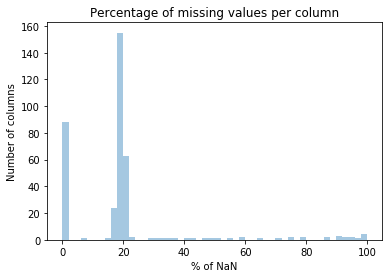

In [116]:
plt.figure()
sns.distplot(col_nan.values, kde=False)
plt.ylabel('Number of columns')
plt.xlabel('% of NaN')
plt.title('Percentage of missing values per column')
plt.show()

In [117]:
# defining colums to drop
col_nan_drop_threshold = col_nan[col_nan > 30]
high_nan_cols = list(col_nan_drop_threshold.index)
# checking columns to be romoved
len(high_nan_cols)
print(high_nan_cols)

['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'EXTSEL992', 'KK_KUNDENTYP', 'MOBI_REGIO', 'PLZ8_BAUMAX']


In [118]:
# dropping high NaN collumns
mailout_train.drop(high_nan_cols, axis = 1, inplace = True)
mailout_train.shape

(42962, 335)

In [119]:
# dropping any attributes related to what cars are prevalent in the area, since I don't think that will be useful infromation.
mailout_train = mailout_train[mailout_train.columns.drop(list(mailout_train.filter(regex='KBA')))]

In [124]:
pd.set_option('max_columns', 200)
mailout_train.head()

,Unnamed: 0,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_MOBILE,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1763,0,1.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,5D,5,34,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,9.0,9.0,0,0,0,3.0,2,7,0,D19_UNBEKANNT,0.0,0,0,0,0,0,0,1.0,0,0,0.0,0,0,0,9,10,10,0.0,6,6,0,1.0,1992-02-10 00:00:00,2004.0,5.0,2.0,5.0,3.0,1.0,1.0,5.0,6.0,2.0,3.0,3.0,0.0,12.0,8.0,0.0,2.0,0.0,6.0,2.0,3.0,4,1.0,1.0,1.0,1.0,8.0,2.0,3.0,2.0,1992.0,1.0,1.0,1.0,7.0,1.0,1.0,4.0,2.0,1.0,2.0,3.0,1.0,5.0,5.0,5.0,2.0,5.0,1.0,6.0,7.0,2.0,6.0,6.0,1.0,7.0,1.0,3.0,2.0,1.0,5.0,1.0,3.0,3.0,0.0,3.0,0.0,2.0,4.0,0.0,4.0,2.0,1.0,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3.0,0,2.0,4.0
1771,1,4.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,5B,5,32,2.0,2.0,2.0,2.0,4.0,3.0,5.0,4.0,0,0,3,0.0,0,0,6,0,0,0,0,6,0,0,0,1.0,8.0,6,6,0,1.0,4,6,0,D19_TELKO_MOBILE,0.0,0,0,0,0,0,6,5.0,0,3,0.0,0,6,0,10,10,10,0.0,0,6,3,1.0,1997-05-14 00:00:00,1994.0,1.0,2.0,3.0,5.0,1.0,1.0,5.0,6.0,4.0,1.0,4.0,1957.0,40.0,8.0,0.0,2.0,0.0,1.0,7.0,2.0,4,4.0,0.0,2.0,2.0,19.0,5.0,9.0,4.0,1994.0,4.0,2.0,2.0,2.0,1.0,3.0,2.0,1.0,0.0,4.0,3.0,8.0,3.0,1.0,2.0,3.0,1.0,3.0,6.0,6.0,1.0,5.0,6.0,3.0,6.0,5.0,5.0,4.0,3.0,1.0,3.0,4.0,2.0,0.0,1.0,0.0,2.0,5.0,0.0,0.0,1.0,1.0,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1.0,0,2.0,3.0
1776,2,1.0,7.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,1.0,2D,2,14,4.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,0,0.0,5,0,0,0,0,0,0,0,0,0,0,6.0,7.0,0,0,0,2.0,2,0,5,D19_LEBENSMITTEL,0.0,0,0,0,0,0,6,2.0,6,0,0.0,0,0,0,10,10,10,0.0,0,6,0,1.0,1995-05-24 00:00:00,1997.0,6.0,1.0,2.0,5.0,1.0,1.0,4.0,5.0,4.0,2.0,4.0,1929.0,11.0,3.0,1.0,1.0,NaN,1.0,3.0,1.0,4,2.0,0.0,0.0,0.0,0.0,0.0,10.0,5.0,1995.0,5.0,1.0,3.0,8.0,2.0,4.0,0.0,0.0,1.0,4.0,3.0,2.0,1.0,4.0,3.0,1.0,5.0,2.0,3.0,3.0,4.0,1.0,3.0,4.0,7.0,6.0,1.0,1.0,5.0,3.0,1.0,7.0,3.0,0.0,3.0,0.0,1.0,5.0,0

In [122]:
#re-encoding OST_WEST_KZ as numeric variable
mailout_train['OST_WEST_KZ'] =  mailout_train['OST_WEST_KZ'].map({'W': 1, 'O': 2})

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [125]:
needs_one_hot= ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP',
                'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP',  
                'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 
                'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB', 
                'LP_STATUS_FEIN', 'LP_STATUS_GROB',
                'NATIONALITAET_KZ','PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 
                'RETOURTYP_BK_S', 'SHOPPER_TYP', 'ZABEOTYP']

In [126]:
#encoding non-sequential categorical variables as one-hot
mailout_train_reselect = pd.get_dummies(mailout_train, columns=needs_one_hot)

In [129]:
mailout_train_reselect.drop('Unnamed: 0', axis =1, inplace = True)

In [137]:
time_stamps_and_references = ['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR', 'MIN_GEBAEUDEJAHR'] 
mailout_train_reselect.drop(time_stamps_and_references , axis = 1 , inplace = True)

In [138]:
mailout_train_reselect.to_csv('mailout_train_reselect.csv', index = 'LNR')

In [6]:
mailout_train_reselect = pd.read_csv('mailout_train_reselect.csv', index_col = 'LNR')

In [7]:
# splitting training data to get a validation/development set
dtrainr, dtestr = train_test_split(mailout_train_reselect, test_size=0.1)

In [8]:
# splitting data into lables and features
labels_trainr = dtrainr['RESPONSE']
data_trainr = dtrainr.drop('RESPONSE', axis=1)
labels_testr = dtestr['RESPONSE']
data_testr = dtestr.drop('RESPONSE', axis=1)

In [9]:
# imputing missing values
imp = SimpleImputer(missing_values=np.nan, strategy='median')
data_trainr_imp = pd.DataFrame(imp.fit_transform(data_trainr.values),
                          columns=data_trainr.columns)
data_testr_imp = pd.DataFrame(imp.transform(data_testr.values),
                          columns=data_testr.columns)

In [10]:
# scaling the data
scaler = RobustScaler()
data_trainr_scaled = pd.DataFrame(scaler.fit_transform(data_trainr_imp.values),
                          columns=data_trainr_imp.columns)
data_testr_scaled = pd.DataFrame(scaler.transform(data_testr_imp.values),
                          columns=data_testr_imp.columns)

In [13]:
xgb_tuned.fit(X = data_trainr_scaled, y = labels_trainr, eval_set = [(data_trainr_scaled, labels_trainr), (data_testr_scaled, labels_testr)], eval_metric='auc', verbose=True)

[0]	validation_0-auc:0.5	validation_1-auc:0.5
[1]	validation_0-auc:0.5	validation_1-auc:0.5
[2]	validation_0-auc:0.5	validation_1-auc:0.5
[3]	validation_0-auc:0.5	validation_1-auc:0.5
[4]	validation_0-auc:0.5	validation_1-auc:0.5
[5]	validation_0-auc:0.500752	validation_1-auc:0.499883
[6]	validation_0-auc:0.500752	validation_1-auc:0.499883
[7]	validation_0-auc:0.500752	validation_1-auc:0.499883
[8]	validation_0-auc:0.500752	validation_1-auc:0.499883
[9]	validation_0-auc:0.500752	validation_1-auc:0.499883
[10]	validation_0-auc:0.5024	validation_1-auc:0.499648
[11]	validation_0-auc:0.5024	validation_1-auc:0.499648
[12]	validation_0-auc:0.72759	validation_1-auc:0.736806
[13]	validation_0-auc:0.76876	validation_1-auc:0.794486
[14]	validation_0-auc:0.777346	validation_1-auc:0.785809
[15]	validation_0-auc:0.780123	validation_1-auc:0.81126
[16]	validation_0-auc:0.792505	validation_1-auc:0.809954
[17]	validation_0-auc:0.793233	validation_1-auc:0.80849
[18]	validation_0-auc:0.799913	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.01, reg_lambda=5, scale_pos_weight=1, seed=1,
              silent=None, subsample=0.5, verbosity=1)

#### Results: 
With the wider feature selection our model performs a lot better. Up to an AUC of 0.8+ on the test partition. We will run Randomized Search CV to see if this model can be further improved by hyper parameter tuning.

### Final Random Algorithm Search

In [15]:
xgb_param_grid= {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'eta': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 75, 100, 150, 200, 375, 500],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5, 1, 2],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.01, 0.5, 1, 2, 5]}

In [23]:
optimize = RandomizedSearchCV(estimator = xgb_tuned,
                              param_distributions = xgb_param_grid,
                              n_iter = 10,
                              scoring='roc_auc',
                              n_jobs = -1,
                              random_state= 1,
                              verbose=10)

In [24]:
optimize.fit(X = data_trainr_scaled, y = labels_trainr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 30.9min remaining:  6.8min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 41.3min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 42.5min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.8, eta=0.1,
                                           gamma=0, learning_rate=0.1,
                                           max_delta_step=0, max_depth=10,
                                           min_child_weight=1, missing=None,
                                           n_estimators=50, n_jobs=-1,
                                           nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0.0...
                                        'eta': [0.01, 0.05, 0.1, 0.2],
                                        'gamma': [0, 0.1, 0.5, 1, 2],
                                     

In [25]:
optimize.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.01, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=10, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1, reg_lambda=5, scale_pos_weight=1, seed=1,
              silent=None, subsample=1.0, verbosity=1)

In [26]:
final_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.01, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=10, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1, reg_lambda=5, scale_pos_weight=1, seed=1,
              silent=None, subsample=1.0, verbosity=1)

In [28]:
final_xgb.fit(X = data_trainr_scaled, y = labels_trainr, 
              eval_set = [(data_trainr_scaled, labels_trainr), (data_testr_scaled, labels_testr)],
              eval_metric='auc', 
              verbose=True, early_stopping_rounds = 10)

[0]	validation_0-auc:0.5	validation_1-auc:0.5
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.5	validation_1-auc:0.5
[2]	validation_0-auc:0.5	validation_1-auc:0.5
[3]	validation_0-auc:0.5	validation_1-auc:0.5
[4]	validation_0-auc:0.5	validation_1-auc:0.5
[5]	validation_0-auc:0.5	validation_1-auc:0.5
[6]	validation_0-auc:0.5	validation_1-auc:0.5
[7]	validation_0-auc:0.5	validation_1-auc:0.5
[8]	validation_0-auc:0.5	validation_1-auc:0.5
[9]	validation_0-auc:0.755809	validation_1-auc:0.807403
[10]	validation_0-auc:0.755809	validation_1-auc:0.807403
[11]	validation_0-auc:0.755809	validation_1-auc:0.807403
[12]	validation_0-auc:0.755809	validation_1-auc:0.807403
[13]	validation_0-auc:0.755809	validation_1-auc:0.807403
[14]	validation_0-auc:0.761201	validation_1-auc:0.812651
[15]	validation_0-auc:0.763307	validation_1-auc:0.811248
[16]	validation_0-auc:0.763482	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.01, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=10, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1, reg_lambda=5, scale_pos_weight=1, seed=1,
              silent=None, subsample=1.0, verbosity=1)

In [29]:
testr_pred = final_xgb.predict_proba(data_testr_scaled)

In [30]:
testr_pred0, testr_pred1 = np.hsplit(testr_pred,2)

In [31]:
roc_auc_score(labels_testr , testr_pred1)

0.8265948862473053

Testing our Model on the whole imbalanced set.

In [32]:
response = mailout_train_reselect['RESPONSE']
reselected_data = mailout_train_reselect.drop('RESPONSE', axis=1)

reselected_data_imp = pd.DataFrame(imp.transform(reselected_data.values),
                          columns=reselected_data.columns)

reselected_data_scaled = pd.DataFrame(scaler.transform(reselected_data_imp.values),
                          columns=reselected_data_imp.columns)

In [33]:
# getting raw probability prediction
probability_response = final_xgb.predict_proba(reselected_data_scaled)

In [34]:
probability_response0, probability_response1 = np.hsplit(probability_response,2)

In [35]:
roc_auc_score(response , probability_response1)

0.7927780430926477

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [83]:
mailout_test = pd.read_csv('Mailout Test.csv', index_col = 'LNR')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [84]:
mailout_test.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,0.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,0.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [85]:
missing_value_checkbook = pd.read_csv("Missing Value CB.csv")

In [86]:
missing_value_checkbook = missing_value_checkbook.filter(items=list(mailout_test.columns))

In [87]:
mailout_test = mailout_test[mailout_test.columns.drop(list(mailout_test.filter(regex='KBA')))]

In [88]:
for att in missing_value_checkbook.columns:
    mailout_test.loc[mailout_test[att].isin(missing_value_checkbook[att]), att] = np.nan

In [89]:
drop_cols = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'EXTSEL992', 'KK_KUNDENTYP', 'MOBI_REGIO', 'PLZ8_BAUMAX', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR', 'MIN_GEBAEUDEJAHR']

In [90]:
mailout_test.drop(drop_cols, axis = 1, inplace = True)

In [91]:
#re-encoding OST_WEST_KZ as numeric variable
mailout_test['OST_WEST_KZ'] =  mailout_test['OST_WEST_KZ'].map({'W': 1, 'O': 2})

In [92]:
needs_one_hot= ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP',
                'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP',  
                'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 
                'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB', 
                'LP_STATUS_FEIN', 'LP_STATUS_GROB',
                'NATIONALITAET_KZ','PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 
                'RETOURTYP_BK_S', 'SHOPPER_TYP', 'ZABEOTYP']

In [93]:
#encoding non-sequential categorical variables as one-hot
mailout_test_cleaned = pd.get_dummies(mailout_test, columns=needs_one_hot)

In [94]:
mailout_test_cleaned.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0
LNR,,,,,,,,,,,,,,,,,,,,,
1754,1.0,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,6.0,...,0,0,0,1,0,0,1,0,0,0
1770,1.0,0.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,7.0,...,0,0,1,0,0,0,1,0,0,0
1465,9.0,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,1.0,...,0,0,0,1,0,0,1,0,0,0
1470,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,...,0,0,0,1,0,0,1,0,0,0
1478,1.0,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,6.0,...,0,0,0,1,0,0,0,1,0,0


In [95]:
# saving cleaned data to csv
mailout_test_cleaned.to_csv('Mailout_Test_Cleaned.csv', index = 'LNR')

In [105]:
# finding columns not in our training set
mailout_test_cleaned.columns.difference(mailout_train_reselect.columns)

Index(['SHOPPER_TYP_-1.0'], dtype='object')

In [106]:
# dropping them
mailout_test_cleaned.drop(mailout_test_cleaned.columns.difference(mailout_train_reselect.columns), axis =1, inplace =True)

In [107]:
# extract LNR from data
lnr = mailout_test_cleaned.index
kaggle_data = mailout_test_cleaned
# impute missing values and scale data
kaggle_data = pd.DataFrame(imp.transform(kaggle_data.values), columns=kaggle_data.columns)
kaggle_data = pd.DataFrame(scaler.transform(kaggle_data.values), columns=kaggle_data.columns)

In [108]:
# predicting lables
kaggle_predictions = final_xgb.predict(kaggle_data)

In [109]:
#predicting probabilities
kaggle_probability_pred = final_xgb.predict_proba(kaggle_data)

In [110]:
kaggle_probability_pred.view()

array([[0.93835425, 0.06164577],
       [0.93086296, 0.06913704],
       [0.95720625, 0.04279373],
       ...,
       [0.94288516, 0.05711483],
       [0.940553  , 0.05944699],
       [0.94334114, 0.05665883]], dtype=float32)

In [111]:
kaggle_probability_pred0, kaggle_probability_pred1 = np.hsplit(kaggle_probability_pred, 2)

In [113]:
kaggle_submission = pd.DataFrame(kaggle_probability_pred1, index=lnr.astype('int32'),
                          columns=['RESPONSE'])

In [114]:
# checking submission
kaggle_submission.head()

,RESPONSE
LNR,
1754,0.061646
1770,0.069137
1465,0.042794
1470,0.041945
1478,0.042348


In [115]:
# ensuring that there are at least some positive predictions
kaggle_submission.RESPONSE.value_counts()

0.046869    6296
0.041945    3996
0.041930    2742
0.042794    2181
0.042334    2075
0.042303    1826
0.042779    1771
0.043190    1218
0.042348    1152
0.045208    1111
0.043159     897
0.044811     808
0.043924     806
0.056708     766
0.043205     759
0.045943     618
0.056216     595
0.057610     499
0.044314     371
0.045224     364
0.044827     292
0.048456     285
0.043939     253
0.055116     237
0.057110     233
0.047500     172
0.057564     170
0.055600     148
0.056963     147
0.060539     139
            ... 
0.060721       1
0.056886       1
0.060723       1
0.066766       1
0.060728       1
0.056823       1
0.060732       1
0.060734       1
0.066786       1
0.082421       1
0.056838       1
0.074617       1
0.066809       1
0.052936       1
0.066810       1
0.060762       1
0.056857       1
0.060766       1
0.066846       1
0.060767       1
0.066852       1
0.056865       1
0.060774       1
0.074675       1
0.066876       1
0.066881       1
0.066883       1
0.056881      

In [116]:
# saving submission
kaggle_submission.to_csv("Kaggle_Submission.csv")